In [11]:
# %% import necessary tools
print("import necessary tools")
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt
import math
import torch
import gpytorch
import pandas as pd
import tqdm as notebook_tqdm

import necessary tools


In [12]:
#%% import data
from sklearn.model_selection import train_test_split
print("import data")
nTrain = 80
df = pd.read_csv('20230628_grainsize.csv')  
df = df.sample(frac=1)
x = df.iloc[:,1:4]
y = df.loc[:,"Estimated Grain Size (nm)"]
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)
x_train = torch.tensor(np.array(x_train))
y_train = torch.tensor(np.array(y_train))
x_test = torch.tensor(np.array(x_test))
y_test = torch.tensor(np.array(y_test))
#x_train = torch.tensor(np.array(x)[:nTrain,:])
#y_train = torch.tensor(np.array(y)[:nTrain])
#noises_train = torch.tensor(np.array(noises)[:nTrain])

#%% pre process data
from sklearn import preprocessing

# need to scale noises only by dividing by stdev of inputs
#noises_train = noises_train/torch.std(x_train)
#noises_train[np.isnan(noises_train)]=np.average(noises_train[np.isnan(noises_train)==False])

# scale x training data per standard scaler to N(0,1)
scaler = preprocessing.StandardScaler().fit(x_train)
x_train = torch.tensor(scaler.transform(x_train))

# apply log to y training data and then scale to N(0,1)
y_train = torch.log(y_train)
y_scaler = preprocessing.StandardScaler().fit(y_train.reshape(-1,1))
y_train = torch.tensor(y_scaler.transform(y_train.reshape(-1,1))).squeeze()
y_test = torch.tensor(y_scaler.transform(y_test.reshape(-1,1))).squeeze()
print(x_train.size())
print(y_train.size())
print(x_test.size())
print(y_test.size())
#noise_scaler = preprocessing.StandardScaler().fit(noises_train.reshape(-1,1))
#noises_train = noise_scaler.transform(noises_train.reshape(-1,1))
#noises_train[np.isnan(noises_train)]=np.average(noises_train[np.isnan(noises_train)==False])
#print(noises_train)

import data
torch.Size([159, 3])
torch.Size([159])
torch.Size([40, 3])
torch.Size([40])


In [13]:
#%%
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=3))
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=3))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
#likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=noises_train,learn_additional_noise=True)
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(x_train, y_train, likelihood)

In [14]:
# %%
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.5)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter=200

print('Starting GP parameter tuning...')
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(x_train)
    # Calc loss and backprop gradients
    loss = -mll(output, y_train)
    loss.backward()
    if np.mod(i,20)==0:
        print('Iter %d/%d - Loss: %.3f   lengthscale 1: %.3f   lengthscale 2: %.3f   lengthscale 3: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale[0][0].item(),
            model.covar_module.base_kernel.lengthscale[0][1].item(),
            model.covar_module.base_kernel.lengthscale[0][1].item(),
        ))
        #print('Iter %d/%d - Loss: %.3f %' (
        #    i + 1, training_iter, loss.item()
            #model.covar_module.base_kernel.lengthscale,
            #model.covar_module.base_kernel.lengthscale[1],
            #model.covar_module.base_kernel.lengthscale[2]
        #))
        #torch.print("lengthscale: "+str(model.covar_module.base_kernel.lengthscale))
    optimizer.step()

Starting GP parameter tuning...
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions 

In [15]:
x_test = torch.tensor(np.array(x)[nTrain:,:])
x_test = torch.tensor(scaler.transform(x_test))
y_test = torch.log(torch.tensor(np.array(y)[nTrain:]))
y_test = torch.tensor(y_scaler.transform(y_test.reshape(-1,1))).squeeze()
#print(y_test)

model.eval()
with torch.no_grad():
    trained_pred_dist = likelihood(model(x_test))
    predictive_mean = trained_pred_dist.mean
    lower, upper = trained_pred_dist.confidence_region()
print(predictive_mean)

# scaling back input/output data
y_test_inverse = y_scaler.inverse_transform(y_test.reshape(-1,1))
x_test_inverse = scaler.inverse_transform(x_test)
predictive_mean_inverse = y_scaler.inverse_transform(predictive_mean.reshape(-1,1))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions

In [16]:
final_nlpd = gpytorch.metrics.negative_log_predictive_density(trained_pred_dist, y_test)
#corr = np.corrcoef(predictive_mean,y_train)[0,1]
print(f'nTrained model NLPD: {final_nlpd:.2f}')
#print('Mean predictions correlated: '+str(corr))

print(y_test)
print(predictive_mean)
print(lower)
print(upper)

nTrained model NLPD: 0.39
tensor([-0.3814, -1.1705, -0.2507, -0.3662, -0.9592,  0.3165, -0.1262, -1.2965,
        -0.3800,  0.6222, -0.7148,  0.7947,  2.0291, -0.7902,  0.4257, -0.7195,
        -0.2924, -0.5873,  0.0318,  1.7199, -0.9300, -0.6626, -0.4980, -0.3563,
        -1.0381,  0.0843, -0.4933,  0.7928, -0.3662, -0.3459, -1.0398, -0.4538,
        -0.2041, -0.5539, -0.7260, -0.0612, -0.5299, -0.3800, -0.4406, -0.6345,
        -0.1981,  1.2640,  1.6184,  0.4648, -0.5930,  0.3181,  1.7169,  1.7235,
        -0.3739,  0.6475, -0.6400, -0.3114, -0.6328,  2.1383, -0.7703,  1.0378,
        -0.6023, -0.2031,  0.7377, -0.2975, -0.5139,  1.7548, -0.5266, -0.9140,
         2.9347, -0.7354, -0.4546,  1.0374, -0.1857, -0.5802, -0.4461, -0.6319,
        -0.5051,  1.2297, -0.3833, -0.9775, -0.5857, -0.8070, -0.8355, -0.8367,
         1.2453,  0.0454, -0.4539, -0.7145, -0.4390, -0.9692,  1.3857,  0.9065,
        -0.4617,  1.6158, -1.1454, -1.0381, -0.4354, -0.4893, -0.6593, -0.7565,
         1.687

119


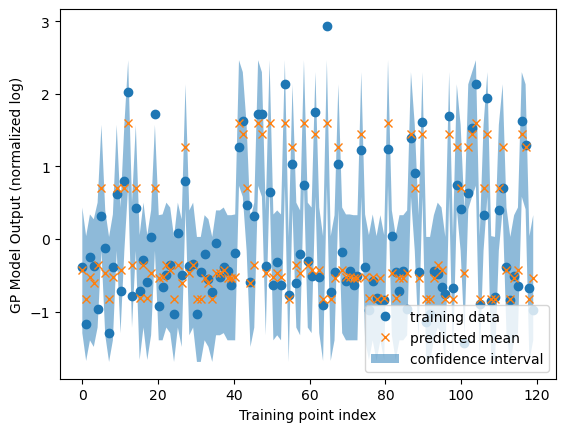

In [17]:
test_size=y_test.size(dim=0)
print(test_size)
testInds = np.linspace(0,int(test_size),num=test_size)
plt.figure()
plt.plot(testInds,y_test,'o',label = 'training data')
plt.plot(testInds,predictive_mean,'x',label='predicted mean')
#plt.plot(testInds,lower,'-',label = 'lower confidence interval')
#plt.plot(testInds,upper,'-',label = 'upper confidence interval')
plt.fill_between(testInds,lower,upper,alpha=0.5, label = 'confidence interval')
plt.xlabel("Training point index")
plt.ylabel("GP Model Output (normalized log)")
plt.legend(loc=4)

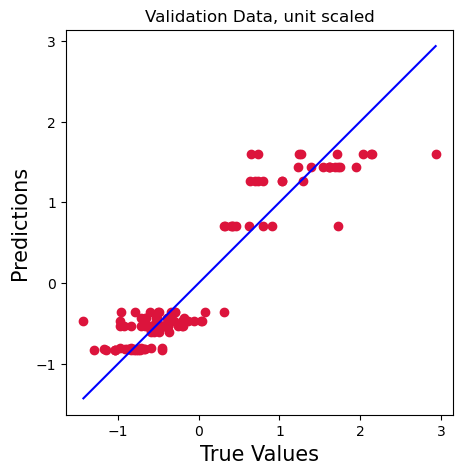

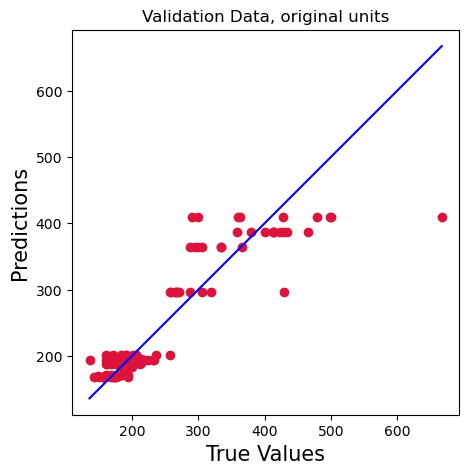

In [18]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, predictive_mean, c='crimson')
#plt.scatter(y_test, lower, c='blue')
#plt.scatter(y_test, upper, c='green')

p1 = max(max(predictive_mean), max(y_test))
p2 = min(min(predictive_mean), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.title("Validation Data, unit scaled")
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(np.exp(y_test_inverse), np.exp(predictive_mean_inverse), c='crimson')
#plt.scatter(y_test, lower, c='blue')
#plt.scatter(y_test, upper, c='green')

p1 = max(max(np.exp(predictive_mean_inverse)), max(np.exp(y_test_inverse)))
p2 = min(min(np.exp(predictive_mean_inverse)), min(np.exp(y_test_inverse)))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.title("Validation Data, original units")
plt.show()

In [19]:
print(model.mean_module.constant)
model.covar_module.base_kernel.lengthscale

Parameter containing:
tensor(0.0292, requires_grad=True)


tensor([[ 2.1565, 11.3014,  0.0500]], grad_fn=<SoftplusBackward0>)